# CS445: Computational Photography
## Programming Project 4: Image-Based Lighting


## Recovering HDR Radiance Maps 

Load libraries and data

https://courses.grainger.illinois.edu/cs445/sp2025/projects/ibl/ComputationalPhotography_ProjectIBL.html

In [44]:
# jupyter extension that allows reloading functions from imports without clearing kernel :D
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
# from google.colab import drive
# drive.mount('/content/drive')

In [46]:
# System imports
from os import path
import math

# Third-Party Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from numpy.ma.core import log

# modify to where you store your project data including utils
datadir = "/home/tars/Projects/UIUC-Computational-Photography/Project_4/" 

utilfn = datadir + "utils"
!cp -r "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .

# can change this to your output directory of choice
!mkdir "images"
!mkdir "images/outputs"

# import starter code
import utils
from utils.io import read_image, write_image, read_hdr_image, write_hdr_image
from utils.display import display_images_linear_rescale, rescale_images_linear
from utils.hdr_helpers import gsolve
from utils.hdr_helpers import get_equirectangular_image
from utils.bilateral_filter import bilateral_filter

cp: '/home/tars/Projects/UIUC-Computational-Photography/Project_4/utils' and './utils' are the same file
cp: '/home/tars/Projects/UIUC-Computational-Photography/Project_4/samples' and './samples' are the same file
mkdir: cannot create directory ‘images’: File exists
mkdir: cannot create directory ‘images/outputs’: File exists


### Reading LDR images

You can use the provided samples or your own images.  You get more points for using your own images, but it might help to get things working first with the provided samples.

In [47]:
# TODO: Replace this with your path and files

imdir = 'samples'
imfns = ['0024.jpg', '0060.jpg', '0120.jpg', '0205.jpg', '0553.jpg']
exposure_times = [1/24.0, 1/60.0, 1/120.0, 1/205.0, 1/553.0]

ldr_images = []
for f in np.arange(len(imfns)):
  im = read_image(imdir + '/' + imfns[f])
  if f==0:
    imsize = int((im.shape[0] + im.shape[1])/2) # set width/height of ball images
    ldr_images = np.zeros((len(imfns), imsize, imsize, 3))
  ldr_images[f] = cv2.resize(im, (imsize, imsize))

background_image_file = imdir + '/' + 'empty.jpg'
background_image = read_image(background_image_file)

### Naive LDR merging 

Compute the HDR image as average of irradiance estimates from LDR images

In [48]:
def make_hdr_naive(ldr_images: np.ndarray, exposures: list) -> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    
    The steps to implement:
    1) Divide each image by its exposure time.
        - This will rescale images as if it has been exposed for 1 second.
    
    2) Return average of above images
    
    
    For further explanation, please refer to problem page for how to do it.
      
    Args:
        ldr_images(np.ndarray): N x H x W x 3  shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposures(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged using
            naive ldr merging implementation.
        (np.ndarray): N x H x W x 3  shaped numpy array represending log irradiances
            for each exposures



    After collecting data, load the cropped images, and resize them to all be square and the same dimensions (e.g. cv2.resize(ldr,(N,N)) 
    where N is the new size). Either find the exposure times using the EXIF data (usually accessible in the image properties), or refer 
    to your recorded exposure times. To estimate the irradiance for each image (up to a scale), divide each intensity by its exposure time 
    (e.g. ldr1_irradiance = ldr1 / exposure_time1). This assumes a direct linear relationship between intensity and total exposure, which is 
    not quite right, but will do for now. Different LDR images will produce different irradiance estimates, so for the naive method, simple 
    compute the average irradiance for each pixel and channel to get your "naive" estimate. To save the HDR image, use the provided 
    write_hdr_image function. To visualize HDR image, you will need to write a display_hdr_image function that maps an arbitrary range 
    to 0 to 1. Some recommendations are made in the Jupyter notebook.

    So.. ensure all images are square
    
    then get the irradiance values for each image. Divide each intensity by its exposure time.. and do this for each pixel. Take the 
    average for each pixel and channel to get the naive estimate

    then save with write_hdr_image function            
    '''
    N, H, W, C = ldr_images.shape                # N is the number of images in ldr_images, H is height of images, W is width of images, 
                                                 # and C is number of channels
    
    assert N == len(exposures)                   # sanity check
  
    hdr_image = np.zeros(ldr_images.shape[1:4])  # creating the output image. We only care about the dimensions describing the image, so 
                                                 # just take 1 to 4
    
    log_irradiances = np.zeros(ldr_images.shape) # since we want to return the irradiance at each pixel, we need an array matching the exact
                                                 # size of the ldr_images array
    
    for i in range(N):                           # for each image
      image = ldr_images[i]                      # current image
      log_irradiances[i] = np.log(1 + image/exposures[i]) - np.log(exposures[i]) # the formula mentioned in the description of the problem:
                                                                                 # divide each intensity by its exposure time.. since we take
                                                                                 # the log exposure, we have to alter it a bit. Add 1 to avoid
                                                                                 # division by 0
        
      hdr_image += image / exposures[i]                                          # straight up way of getting irradiance. Sum this across all the images

    hdr_image = hdr_image/N                                                      # get the average across all images  
  
    return hdr_image, log_irradiances

In [49]:
def display_hdr_image(im_hdr):
    '''
    Maps the HDR intensities into a 0 to 1 range and then displays. 
    Three suggestions to try: 
      (1) Take log and then linearly map to 0 to 1 range (see display.py for example) 
      (2) img_out = im_hdr / (1 + im_hdr)
      (3) HDR display code in a python package 
    '''
    tonemap = cv2.createTonemap(2.2)
    img_out = tonemap.process(im_hdr.copy().astype(np.float32))

    plt.figure(figsize=(5,5))
    plt.imshow(img_out)

HDR Image


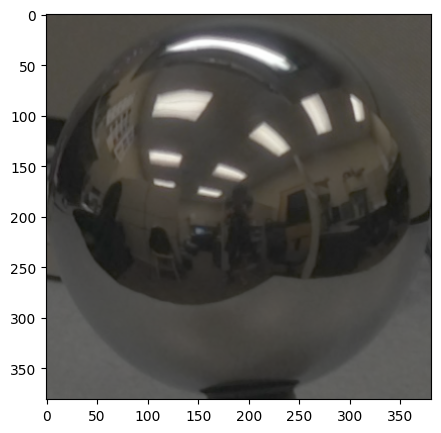

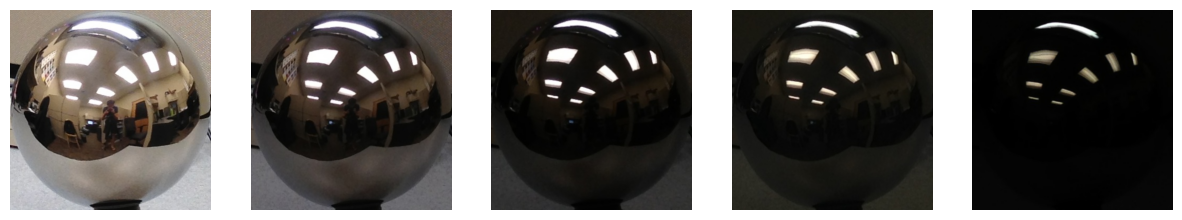

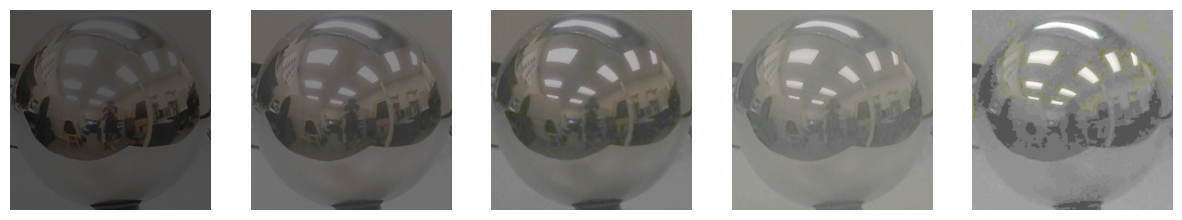

In [50]:
# get HDR image, log irradiance
naive_hdr_image, naive_log_irradiances = make_hdr_naive(ldr_images, exposure_times)

# write HDR image to directory
write_hdr_image(naive_hdr_image, 'images/outputs/naive_hdr.hdr')

# display HDR image
print('HDR Image')
display_hdr_image(naive_hdr_image)

# display original images (code provided in utils.display)
display_images_linear_rescale(ldr_images)

# display log irradiance image (code provided in utils.display)
display_images_linear_rescale(naive_log_irradiances)

### Weighted LDR merging 

Compute HDR image as a weighted average of irradiance estimates from LDR images, where weight is based on pixel intensity so that very low/high intensities get less weight


In [51]:
def make_hdr_weighted(ldr_images: np.ndarray, exposure_times: list) -> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    
    The steps to implement:
    1) compute weights for images with based on intensities for each exposures
        - This can be a binary mask to exclude low / high intensity values

    2) Divide each images by its exposure time.
        - This will rescale images as if it has been exposed for 1 second.
    
    3) Return weighted average of above images
    
    
    Args:
        ldr_images(np.ndarray): N x H x W x 3 shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposure_times(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged without
            under - over exposed regions

    The naive method has an obvious limitation: if any pixels are under- or over-exposed, the result will contain clipped (and thus incorrect) information.
    Instead of using an unweighted average, create a weighting function (or array) that maps each pixel intensity into a weight, where pixel values close to 
    0 or 255 (in a 0 to 255 range) have weights close to 0, and pixel intensities close to 128 have weights close to 1. One such weighting function is 
    w = lambda z: float(128-abs(z-128)) assuming pixel values range in [0,255]. Note that the weight is a function of intensity, but the sum is over irradiance, 
    which can have larger values than maximum LDR intensity. To compute a weighted average of irradiance, compute a weighted sum of irradiances and then divide 
    by the sum of weights for each pixel.

    So.. why do we need to do this weighted method? It is because, as the above description says, the naive method has issues with clipped values. Any value that
    is super dark, or super bright, will be captured as a 0 or 255.. these are clipped values, as they are not actually 255 values.. the sensor just capped out at
    that measurement. This corrupts the result.

    Therefore, the idea here is to "trust" values in the mid-range more than those in the super low or super high ranges. Super dark or super bright values will
    have weights close to 0, with intensity values close to 128 will have weights of 1. 

    .. "To compute a weighted average of irradiance, compute a weighted sum of irradiances and then divide 
    by the sum of weights for each pixel."
    '''
    N, H, W, C = ldr_images.shape
    assert N == len(exposure_times)                         # sanity check

    hdr_image = np.zeros(ldr_images.shape[1:4])              
    
    tot_weight = np.zeros(ldr_images.shape[1:4])            # this way we can track the weight for each pixel, in each channel
    
    w = np.vectorize(lambda z: float(128-abs(z-128)))       # here is the weighting function described in the instructions
    
    for i in range(N):                                      # for each image
        image = ldr_images[i]                               # Explicit float conversion for stability
        
        weights = w(image)                                 # calculate the weights for each pixel in each channel
        
        tot_weight += weights                              # Accumulate weights (per-pixel, per-channel)
        
        hdr_image += (image / exposure_times[i]) * weights # add weighted irradiance
    
    
    hdr_image = hdr_image / (tot_weight + (1/1000000))     # compute weighted average by normalizing by total weight.. add a small value to prevent div by 0
    
    hdr_image[hdr_image == 0] = 0.000001                   # replace any remaining zeros with small value (avoid log(0) issues later)

    return hdr_image

Weighted


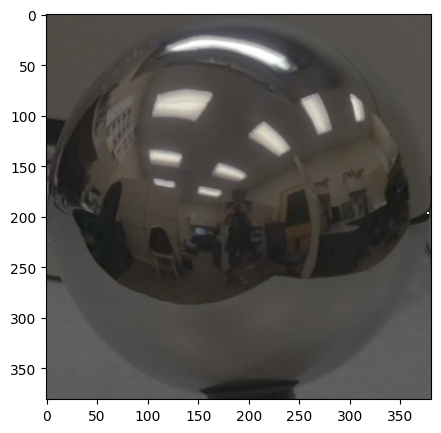

In [52]:
# get HDR image, log irradiance
weighted_hdr_image = make_hdr_weighted(ldr_images, exposure_times)

# write HDR image to directory
write_hdr_image(weighted_hdr_image, 'images/outputs/weighted_hdr.hdr')

print("Weighted")

# display HDR image
display_hdr_image(weighted_hdr_image)

Naive


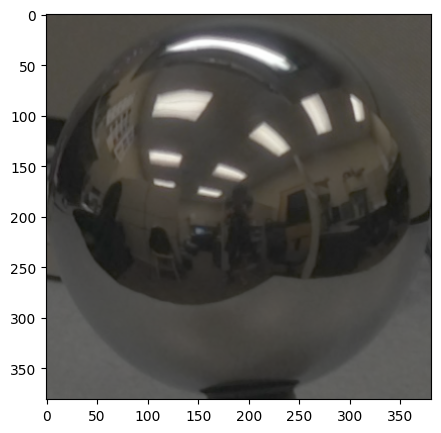

In [53]:
print("Naive")
display_hdr_image(naive_hdr_image)

Display of difference between naive and weighted for your own inspection

Where does the weighting make a big difference increasing or decreasing the irradiance estimate?  Think about why.

Min ratio =  0.7605717255098593   Max ratio =  2.9129149372357817


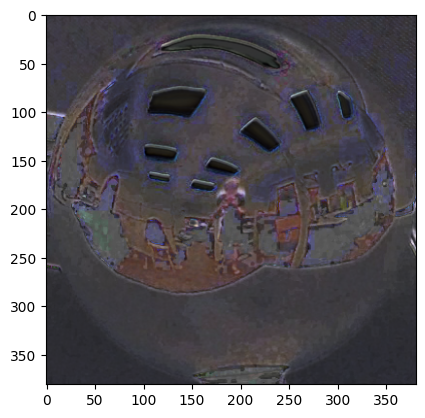

In [54]:
# display difference between naive and weighted 

log_diff_im = np.log(weighted_hdr_image)-np.log(naive_hdr_image)
print('Min ratio = ', np.exp(log_diff_im).min(), '  Max ratio = ', np.exp(log_diff_im).max())
plt.figure()
plt.imshow(rescale_images_linear(log_diff_im))

### LDR merging with camera response function estimation 

Compute HDR after calibrating the photometric reponses to obtain more accurate irradiance estimates from each image

Some suggestions on using <tt>gsolve</tt>:
<ul>
	<li>When providing input to gsolve, don't use all available pixels, otherwise you will likely run out of memory / have very slow run times. To overcome, just randomly sample a set of pixels (1000 or so can suffice), but make sure all pixel locations are the same for each exposure.</li>
	<li>The weighting function w should be implemented using Eq. 4 from the paper (this is the same function that can be used for the previous LDR merging method).</li>
	<li>Try different lambda values for recovering <i>g</i>. Try lambda=1 initially, then solve for <i>g</i> and plot it. It should be smooth and continuously increasing. If lambda is too small, g will be bumpy.</li>
	<li>Refer to Eq. 6 in the paper for using g and combining all of your exposures into a final image. Note that this produces log irradiance values, so make sure to exponentiate the result and save irradiance in linear scale.</li>
</ul>

In [55]:
def make_hdr_estimation(ldr_images: np.ndarray, exposure_times: list, lm)-> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    Please refer to problem notebook for how to do it.
    
    **IMPORTANT**
    The gsolve operations should be ran with:
        Z: int64 array of shape N x P, where N = number of images, P = number of pixels
        B: float32 array of shape N, log shutter times
        l: lambda; float to control amount of smoothing
        w: function that maps from float intensity to weight  
    The steps to implement:
    1) Create random points to sample (from mirror ball region)
    2) For each exposures, compute g values using samples
    3) Recover HDR image using g values
    

    Args:
        ldr_images(np.ndarray): N x H x W x 3 shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposures(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
        lm (scalar): the smoothing parameter
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged using
            gsolve
        (np.ndarray): N x H x W x 3 shaped numpy array represending log irradiances
            for each exposures
        (np.ndarray): 3 x 256 shaped numpy array represending g values of each pixel intensities
            at each channels (used for plotting)
    '''
    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposure_times)
    print("ldr_images shape: ", ldr_images.shape)
    
    # TO DO: implement HDR estimation using gsolve
    # gsolve(Z, B, l, w) -> g, lE

    # print(type(ldr_images),type(exposure_times)) #print data types of parameters

    # 1) Create random points to sample (from mirror ball region)
    P = 5000
    rx = np.random.randint(W,size=P)
    ry = np.random.randint(H,size=P)
    B = np.log(exposure_times).astype(np.float32)
    lam = 5

    # Scale image to be between 0 and 255
    sldr_images = ldr_images*255
    hdr_image = np.zeros(sldr_images.shape[1:4])
    log_irradiances = np.zeros(sldr_images.shape) # we will return array of irradiances at each pixel/channel
    g = np.zeros([3,256])
    le = np.zeros([3,P])
    w = lambda z: float(128-abs(z-128))
    ws = [w(z) for z in range(256)]
    w = np.vectorize(w)

    # Need to call gsolve for each channel since it returns g value per intensity as 256x1
    
    for c in range(C):
      # print("Solve",c,"Started")
      Z = sldr_images[:,ry,rx,c].astype(np.int64)
      # print("z shape:",Z.shape,"B shape:",B.shape)

      # 2) For each exposures, compute g values using samples
      g[c],le[c] = gsolve(Z,B,lam,ws) #We need new g mapping for each ldr image
      fg = np.vectorize(lambda x: g[c][int(x)])
    
      num = np.zeros((H,W)); #numerator sum
      tot_weight = np.zeros((H,W));

      # Need to weighted average pixel intensities over n
      for i in range(N): #loop through each image
        image = (sldr_images[i,:,:,c]) # image is one ldr image, one channel: H x W x 1
        weights = w(image) # weights is weighted values in H x W x 1
        
        # 3) Recover HDR image using g values
        log_irradiances[i,:,:,c] = fg(image) - B[i]
        num += weights*(log_irradiances[i,:,:,c])
        tot_weight += weights
      
      hdr_image[:,:,c] = num / tot_weight
      hdr_image[hdr_image < 0] = 0.000001 # Need this to get rid of div by 0 errors

    return hdr_image, log_irradiances, g
    

ldr_images shape:  (5, 381, 381, 3)


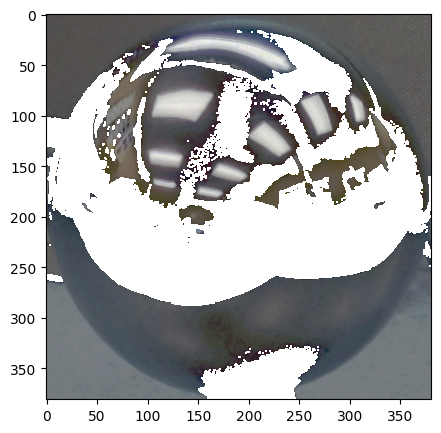

In [56]:
lm = 5
# get HDR image, log irradiance
calib_hdr_image, calib_log_irradiances, g = make_hdr_estimation(ldr_images, exposure_times, lm)

# write HDR image to directory
write_hdr_image(calib_hdr_image, 'images/outputs/calib_hdr.hdr')

# display HDR image
display_hdr_image(calib_hdr_image)


The following code displays your results. You can copy the resulting images and plots directly into your report where appropriate.

In [58]:
print("Calibrated HDR Image Min/Max Before Clipping:", calib_hdr_image.min(), calib_hdr_image.max())
print("Weighted HDR Image Min/Max Before Clipping:", weighted_hdr_image.min(), weighted_hdr_image.max())

# Clip values to avoid negative values
# calib_hdr_image = np.clip(calib_hdr_image, a_min=0, a_max=None)
# weighted_hdr_image = np.clip(weighted_hdr_image, a_min=0, a_max=None)

print("Calibrated HDR Image Min/Max After Clipping:", calib_hdr_image.min(), calib_hdr_image.max())
print("Weighted HDR Image Min/Max After Clipping:", weighted_hdr_image.min(), weighted_hdr_image.max())

Calibrated HDR Image Min/Max Before Clipping: 1e-06 4.855344817893472
Weighted HDR Image Min/Max Before Clipping: 0.5762156206984779 192.76993184571006
Calibrated HDR Image Min/Max After Clipping: 1e-06 4.855344817893472
Weighted HDR Image Min/Max After Clipping: 0.5762156206984779 192.76993184571006


Min ratio =  2.786912740567459e-06   Max ratio =  2.015552540035634


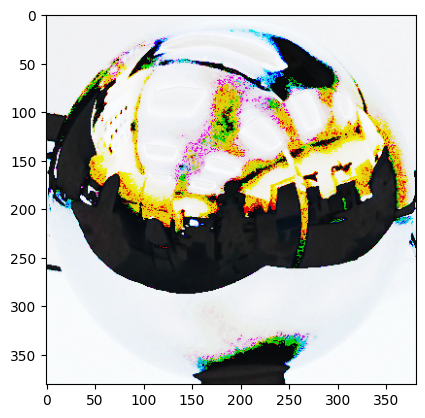

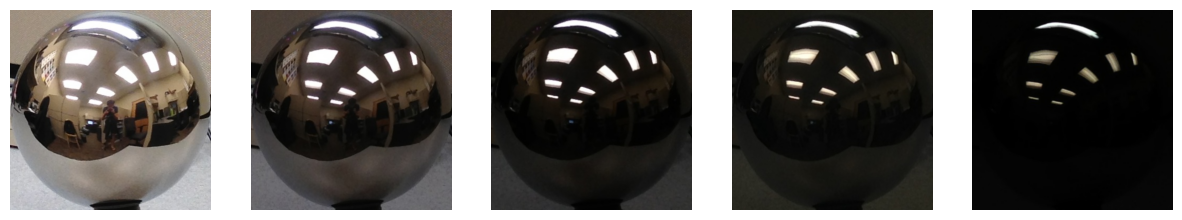

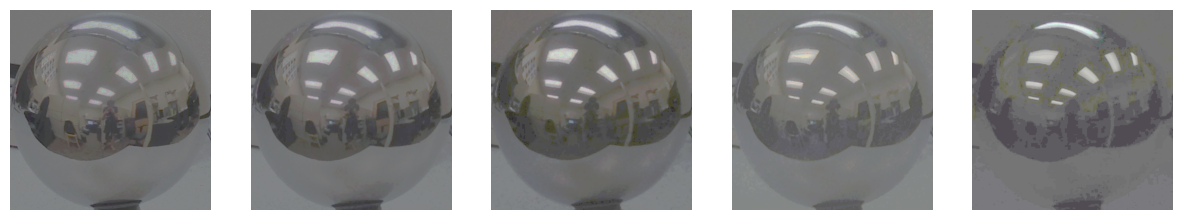

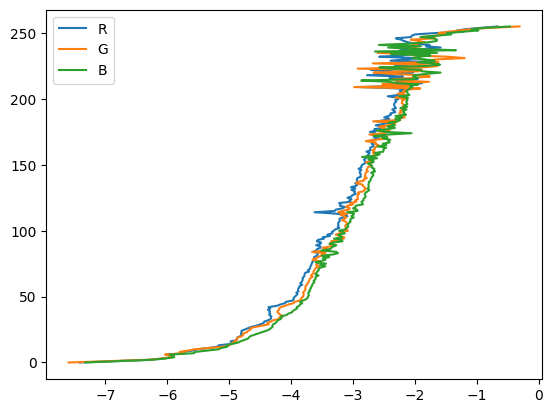

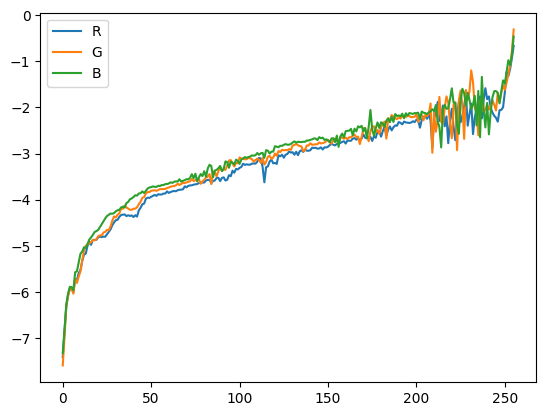

In [59]:
# display difference between calibrated and weighted
log_diff_im = np.log(calib_hdr_image/calib_hdr_image.mean())-np.log(weighted_hdr_image/weighted_hdr_image.mean())
print('Min ratio = ', np.exp(log_diff_im).min(), '  Max ratio = ', np.exp(log_diff_im).max())
plt.figure()
plt.imshow(rescale_images_linear(log_diff_im))

# display original images (code provided in utils.display)
display_images_linear_rescale(ldr_images)

# display log irradiance image (code provided in utils.display)
display_images_linear_rescale(calib_log_irradiances)

# plot g vs intensity, and then plot intensity vs g
N, NG = g.shape
labels = ['R', 'G', 'B']
plt.figure()
for n in range(N):
    plt.plot(g[n], range(NG), label=labels[n])
plt.gca().legend(('R', 'G', 'B'))

plt.figure()
for n in range(N):
    plt.plot(range(NG), g[n], label=labels[n])
plt.gca().legend(('R', 'G', 'B'))

naive:  	log range =  6.462 	avg RMS error =  4.909
weighted:	log range =  5.813 	avg RMS error =  4.873
calibrated:	log range =  15.396 	avg RMS error =  4.576


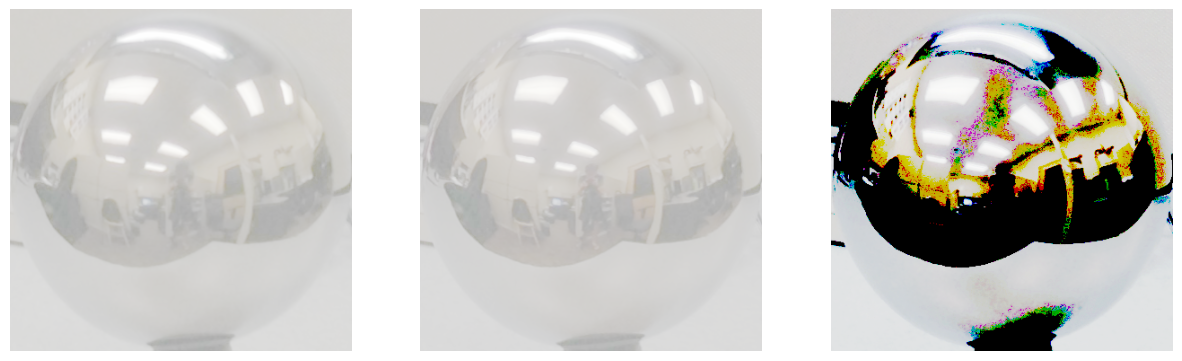

In [60]:
def weighted_log_error(ldr_images, hdr_image, log_irradiances):
  # computes weighted RMS error of log irradiances for each image compared to final log irradiance
  N, H, W, C = ldr_images.shape
  w = 1-abs(ldr_images - 0.5)*2
  err = 0
  for n in np.arange(N):
    err += np.sqrt(np.multiply(w[n], (log_irradiances[n]-np.log(hdr_image))**2).sum()/w[n].sum())/N 
  return err


# compare solutions
err = weighted_log_error(ldr_images, naive_hdr_image, naive_log_irradiances)
print('naive:  \tlog range = ', round(np.log(naive_hdr_image).max() - np.log(naive_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))
err = weighted_log_error(ldr_images, weighted_hdr_image, naive_log_irradiances)
print('weighted:\tlog range = ', round(np.log(weighted_hdr_image).max() - np.log(weighted_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))
err = weighted_log_error(ldr_images, calib_hdr_image, calib_log_irradiances)
print('calibrated:\tlog range = ', round(np.log(calib_hdr_image).max() - np.log(calib_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))

# display log hdr images (code provided in utils.display)
display_images_linear_rescale(np.log(np.stack((naive_hdr_image/naive_hdr_image.mean(), weighted_hdr_image/weighted_hdr_image.mean(), calib_hdr_image/calib_hdr_image.mean()), axis=0)))

## Panoramic transformations 

Compute the equirectangular image from the mirrorball image

In [61]:
def panoramic_transform(hdr_image):
    '''
    Given HDR mirror ball image, 
    
    Expects mirror ball image to have center of the ball at center of the image, and
    width and height of the image to be equal.
    
    Steps to implement:
    1) Compute N image of normal vectors of mirror ball
    2) Compute R image of reflection vectors of mirror ball
    3) Map reflection vectors into spherical coordinates
    4) Interpolate spherical coordinate values into equirectangular grid.
    
    Steps 3 and 4 are implemented for you with get_equirectangular_image

    '''
    H, W, C = hdr_image.shape
    assert H == W
    assert C == 3

    # TO DO: compute N and R
        
    # R = V - 2 * dot(V,N) * N


    
    plt.imshow((N+1)/2)
    plt.show()
    plt.imshow((R+1)/2)
    plt.show()

    equirectangular_image = get_equirectangular_image(R, hdr_image)
    return equirectangular_image

In [62]:
def panoramic_transform(hdr_image):
    '''
    Given HDR mirror ball image, 
    
    Expects mirror ball image to have center of the ball at center of the image, and
    width and height of the image to be equal.
    
    Steps to implement:
    1) Compute N image of normal vectors of mirror ball
    2) Compute R image of reflection vectors of mirror ball
    3) Map reflection vectors into spherical coordinates
    4) Interpolate spherical coordinate values into equirectangular grid.
    
    Steps 3 and 4 are implemented for you with get_equirectangular_image

    '''
    H, W, C = hdr_image.shape
    assert H == W
    assert C == 3

    # TO DO: compute N and R
    
    mask = np.zeros([H,W])
    N = np.zeros([H,W,3])
    for u in range(W):
      for v in range (H):
        Nx = (u-W/2)/(W/2)
        Ny = (v-H/2)/(H/2)
        Nz = np.sqrt(1.0 - np.clip(np.square(Nx) + np.square(Ny),0,1))
        N[v,u,:] = np.array([Nx,Ny,Nz])
        if(np.square(Nx) + np.square(Ny) < 1):
          mask[v,u] = 1.0

    N[:,:,0] *= mask
    N[:,:,1] *= mask
    
    V = np.zeros((H,W,C))
    R = np.zeros((H,W,C))
    V = np.array([0,0,-1])
    for i in range(H):
      for j in range(W):
        R[i,j,:] = V - 2*np.dot(V,N[i,j,:])*N[i,j,:] # R = V - 2*dot(V,N)*N
    for c in range(C):
      R[:,:,c] *= mask # Make all pixels outside sphere gray

    # Print images
    plt.imshow((N+1)/2)
    plt.show()
    plt.imshow((R+1)/2)
    plt.show()
    
    equirectangular_image = np.float32(get_equirectangular_image(R, hdr_image))
    return equirectangular_image

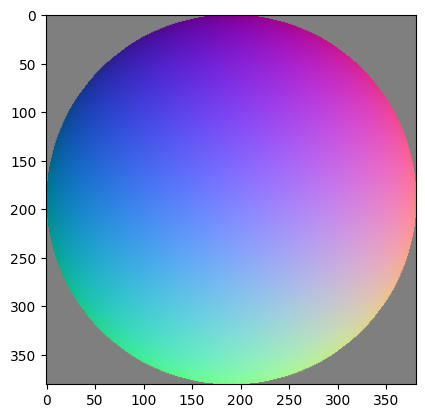

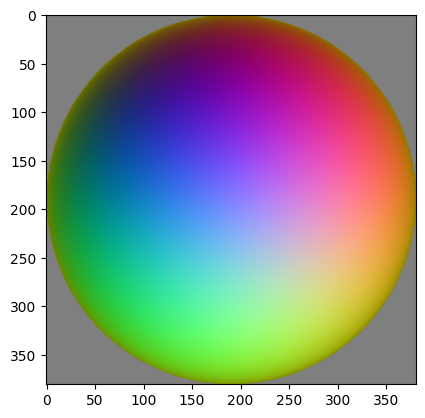

<Figure size 1500x1500 with 0 Axes>

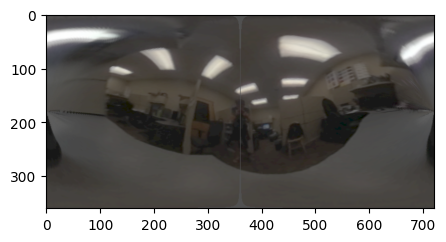

In [64]:
hdr_mirrorball_image = read_hdr_image('images/outputs/weighted_hdr.hdr')
eq_image = panoramic_transform(hdr_mirrorball_image)

write_hdr_image(eq_image, 'images/outputs/equirectangular.hdr')

plt.figure(figsize=(15,15))
display_hdr_image(eq_image)


---

## Rendering synthetic objects into photographs 

Use Blender to render the scene with and with objects and obtain the mask image.  The code below should then load the images and create the final composite.

In [23]:
# Read the images that you produced using Blender.  Modify names as needed.
O = read_image('images/proj4_objects.png')
E = read_image('images/proj4_empty.png')
M = read_image('images/proj4_mask.png')
M = M > 0.5
I = background_image
I = cv2.resize(I, (M.shape[1], M.shape[0]))

[ WARN:0@13.327] global loadsave.cpp:268 findDecoder imread_('images/proj4_objects.png'): can't open/read file: check file path/integrity


TypeError: 'NoneType' object is not subscriptable

In [ ]:
# TO DO: compute final composite
result = []

plt.figure(figsize=(20,20))
plt.imshow(result)
plt.show()

write_image(result, 'images/outputs/final_composite.png')

---


## Bells & Whistles (Extra Points)

### Additional Image-Based Lighting Result 


### Other panoramic transformations 


### Photographer/tripod removal 


### Local tonemapping operator 

